# 3He Detector Absorption Effect on C1

We want to study the effect of various thicknesses of 3He proportional counter on the computation of C1 using the Chopper. 

I want to start by reproducing the C1 result from 2 years ago. The standard spectrum file was
`Bl3WFrontAdjGridBack_5p4cmSq/IntensityVsWavelength_Big.csv`
which is the output of a full-area detector in the mc_stas model that we used to study segmenting the neutron detector.

First we have to load some resources.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/bcollett/Research/BL3/NeutronSpectrum/mcstas_local/pytools')
from nspectrum import NSpectrum

Then we can load in the full spectrum

In [4]:
full = NSpectrum('IntensityVsWavelength_Big.csv')

Spectrum has {self.n_data} channels


and plot it.

529785833.4233938
<class 'matplotlib.figure.Figure'> Figure(1000x500)


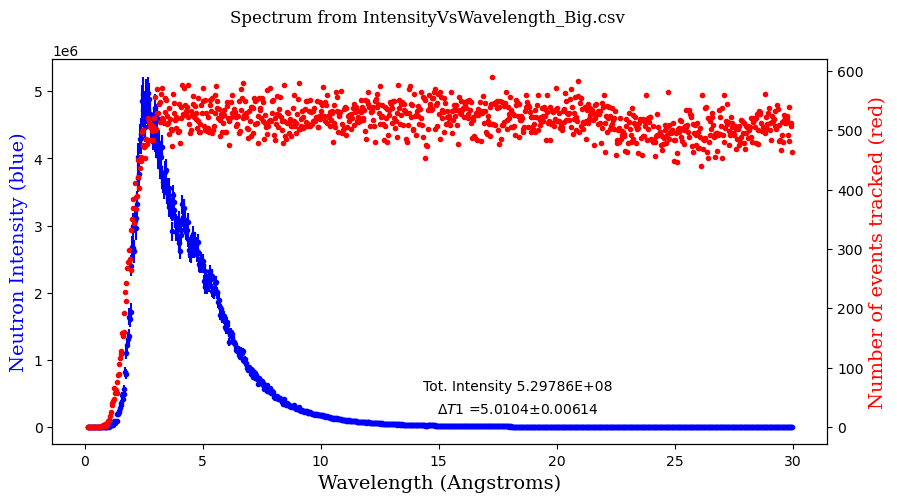

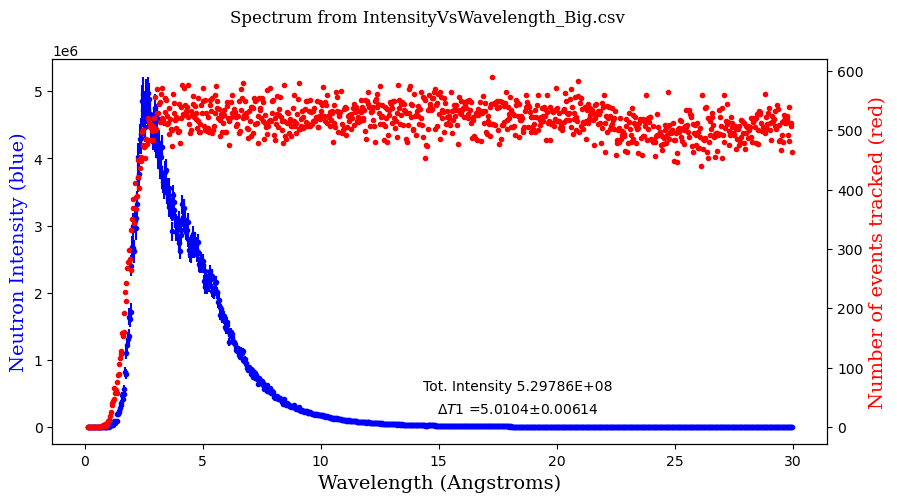

In [5]:
full.plot()

Not sure why I got two of them. But it is clearly what we expect for a spectrum.

Now load in the C1 code.

In [6]:
from scipy.integrate import simps

class Correction:
    def __init__(self):
        self.rho = 39.3E-6 / 1e-4  # LiF density, g/m^2
        self.sigma = 941E-28  # m^2 reference absorbtion
        self.ArealDensity = 6.01512  # g/mol
        self.C0 = self.rho * self.sigma * physics.N_A / self.ArealDensity
        self.kn = physics.hc * physics.c / physics.m_n
        # print(f'kn = {self.kn}')
        # print(f'C0 = {self.C0}')
        self.v0 = 2200  # m/s Reference velocity for absorbtion
        self.lamb0 = self.kn / self.v0  # Angstroms reference wavelength
        # print(self.lamb0)
        self.tau_n = 886.3  # s Neutron lifetime

    def C1_Scott(self, lamb, inten):
        # Numerator integral
        num = np.sum(self.C0 * lamb * inten / self.lamb0)
        # print(num)
        # Denominator
        pre = 1 - np.exp(-self.C0 * lamb / self.lamb0)
        denom = np.sum(pre * inten)
        # print(denom)
        C1 = num / denom
        # print(f"Scott's 'C1 = {C1}")
        return C1

    def C1_BC(self, lamb, inten):
        # Numerator integral
        num = simps(self.C0 * lamb * inten / self.lamb0, lamb)
        # print(num)
        # Denominator
        pre = 1 - np.exp(-self.C0 * lamb / self.lamb0)
        denom = simps(pre * inten, lamb)
        # print(denom)
        C1 = num / denom
        # print(f"BC's C1 = {C1}")
        return C1

    def C1ToCorr(self, C1):
        return self.tau_n * (C1 - 1)

    def CorrScott(self, lamb, inten):
        return self.C1ToCorr(self.C1_Scott(lamb, inten))

    def CorrBC(self, lamb, inten):
        return self.C1ToCorr(self.C1_BC(lamb, inten))

class Physics:
    def __init__(self): # Particle rest masses in eV/c^2
        self.m_e = 0.510998950E6  # eV/c^2
        self.m_p = 938.272088E6
        self.m_n = 939.565420E6
        # hc converts between wavelength and momentum (pc in eV)
        self.hc = 12_398.4  # eV.nm
        self.c = 299_792_458  # m/s
        # Avogadro's number
        self.N_A = 6.02214076E23  # /mol

physics = Physics()
c = Correction()


The C1 routines take a spectrum as two separate arrays so we have to split up our data.

In [7]:
mc_errs = full.data[:, 2]
mc_inten = full.data[:, 1]
mc_ls = full.data[:, 0]


Now we can calculate C1.

In [8]:
fullC1 = c.CorrBC(mc_ls, mc_inten)

print(f'Full C1 = {fullC1} s')

Full C1 = 5.010633777511635 s


Since that agrees with our previous value, the method and data are validated.

## Detection

We are exploring using 3He proportional counters. They have the potential problem that they might not be thick enough to absorb all the incident neutrons. Worse, the absorption probability is wavelength dependent, exactly like the 6Li deposit so we face the same wavelength dependence that we are trying to measure. The big difference is that the 6Li deposit is very thin and absorbs very few neutrons while the 3He is thick and aborbs most of the neutrons.

For thermal neutrons, $\lambda=1.8$ A, the absorption cross-section of 3He is 5330 Barns. The cross-section is proportional to wavelength so
$$\sigma=\dfrac{5330 \lambda}{1.8}$$
where $\sigma$ is in Barns and $\lambda$ in Angstroms.

The tranmission through a length L of material containing $n$ 3He atoms per unit volume is given by
$$\dfrac{N_{out}}{N_{in}}=e^{-n\sigma{}L}$$
so that the probability of detection is
$$P=1-e^{-n\sigma{}L}$$

We can create such a transmission function for our neutrons if we know the number density of 3He atoms. The detectors under consideration have a pressure of 10 atm so we can use the fact that 1 Mole of gas, $6.22\times{}10^23$ atoms, occupy 22.4 litres at STP. At 10 atm the volume will be reduced by a factor of 10 so that the gas number density is
$$n = \dfrac{6.22\times{}10^{23}}{2.24\times{}10^{-3}}=2.78\times10^{26}\,m^{-3}.$$

In [10]:
sigma0 = 5330e-28 # m^2
l0 = 1.8 # Angstroms
n = 6.22e23 / 2.24e-3
def sigma(l):
  return l * (sigma0 / l0)
def prob(l, L):
  return 1 - np.exp(-n * sigma(l) * L)

So for a 0.75" detector tube L~1.9 cm = 0.019m and we can use the wavelength list for our spectrum to generate an absorption function.

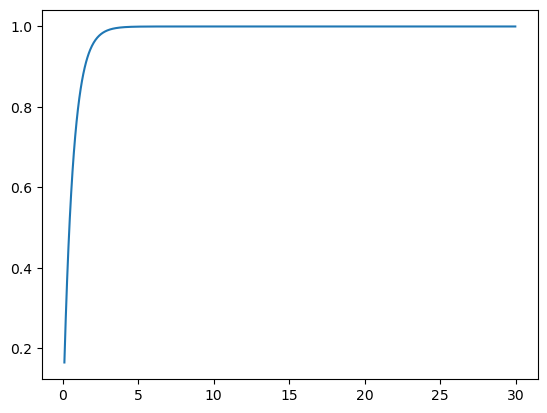

In [12]:
abs075=prob(mc_ls, 0.019)
plt.plot(mc_ls, trans075)

Extremely believable. We lose a significant number of the fastest neutrons but collect essentially all the medium to slow neutrons.

Now we can modify the spectrum with the absorption function and re-calculate C1.

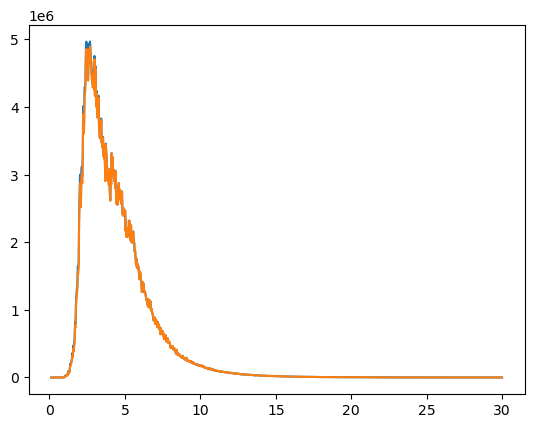

In [13]:
iabs = mc_inten * abs075
plt.plot(mc_ls, mc_inten, mc_ls, iabs)

In [16]:
abs075C1 = c.CorrBC(mc_ls, iabs)

print(f'3/4 inch C1 = {abs075C1} s')
print(f'Difference = {fullC1 - abs075C1}')

3/4 inch C1 = 5.024128272290283 s
Difference = -0.013494494778647947
